# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Проверка гипотезы о пользователях приложения Яндекс.Книги из Санкт-Петербурга и Москвы.

- Автор: Матвеев Д.А., группа DA-123
- Дата:15.09.2025 г.

## Цели и задачи проекта

<font color='#777778'>Цель проекта - проверить гипотезу: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

Задачи проекта: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента. .

## Описание данных

<font color='#777778'>Для анализа были использованы данные из файла yandex_knigi_data.csv, содержащего информацию об активности пользователей в приложении для чтения и прослушивания книг

 - city - Город проживания пользователя (Москва или Санкт-Петербург)
 - puid - Уникальный идентификатор пользователя
 - hours - Суммарное время активности пользователя в приложении (в часах)</font>

## Содержимое проекта

<font color='#777778'>

- Загрузка данных и знакомство с ними
- Предварительный анализ данных
- Проверка гипотезы в Python
- Составление аналитической записки</font>

---

## Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


Датасет содержит 4 столбца и 8784 строки. После первичного анализа данных можно сделать следующие выводы:

- Значения в столбцах Unnamed: 0, puid представлены типом данных int.
- Столбец city представлен уникальным типом данных object.
- Cтолбец hours - тип данных float.
- Пропусков в столбцах нет.

## Предварительный анализ данных

Проверим дубликаты и уникальных пользователей:

In [3]:
dublicates = df.duplicated().sum()
unique_id = df['puid'].nunique()


print (f' Полных дубликатов: {dublicates}, уникальных пользователей: {unique_id}')

 Полных дубликатов: 0, уникальных пользователей: 8540


In [4]:
unique_id_1 =len(df['puid'].unique())

print (f' Уникальных записей: {unique_id_1}.')

 Уникальных записей: 8540.


In [5]:
unique_id_2 = df.duplicated(subset=['puid']).sum()

print (f' Неявных дубликатов: {unique_id_2}.')

 Неявных дубликатов: 244.


Количество уникальных пользователей отличается от количества записей - 8540 и 8784 - как раз на количество неявных дубликатов. Вероятно некоторые пользователи зашли из обоих городов. Почистим датайфрейм, удалив их:



In [6]:
clean_df = df.drop_duplicates(subset=['puid'], keep = 'first') 
print (f' Количество строк в очищенном датафрейме: {len(clean_df)}')

 Количество строк в очищенном датафрейме: 8540


Посмотрим распределение по городам:

In [7]:
users_by_city_1 = clean_df['city'].value_counts()
users_by_city_2 = clean_df['city'].value_counts(normalize=True)

display(users_by_city_1)
display(users_by_city_2)

Москва             6234
Санкт-Петербург    2306
Name: city, dtype: int64

Москва             0.729977
Санкт-Петербург    0.270023
Name: city, dtype: float64

По распределению пользователей по городам видно, что в Москве почти в 3 раза больше выборка. Посчитаем статистические показатели по столбцу hours:

In [8]:
stats = clean_df.groupby('city')['hours'].agg(
        count='count',
        mean='mean',
        max='max',
        min='min',
        median='median',
        std='std')

stats

,count,mean,max,min,median,std
city,,,,,,
Москва,6234,10.881092,857.209373,0.000018,0.924498,36.851683
Санкт-Петербург,2306,11.264433,978.764775,0.000025,0.875355,39.831755


По сводной таблице видно, что есть разница между медианой и средним количество прослушанных часов, это значит что, скорее всего,данные распределены неравномерно и есть выбросы. Изобразим график распределения hours.

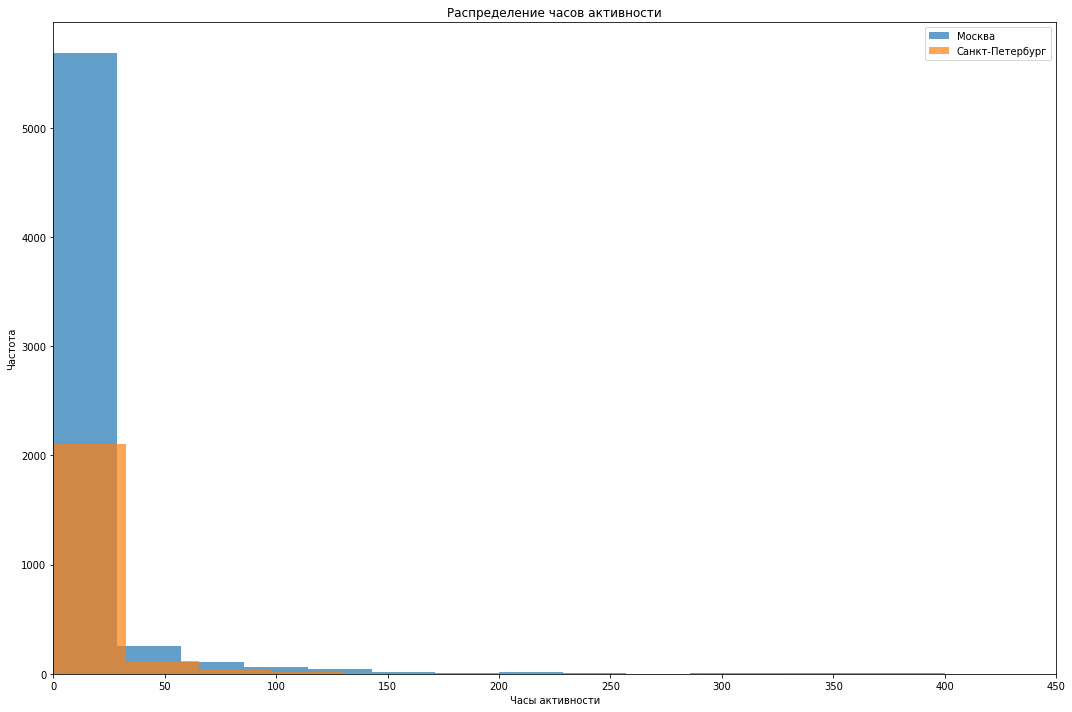

In [9]:
moscow_hours = clean_df[clean_df['city'] == 'Москва']['hours']
spb_hours = clean_df[clean_df['city'] == 'Санкт-Петербург']['hours']

plt.figure(figsize=(15, 10))
plt.hist(moscow_hours, bins=30, alpha=0.7, label='Москва')
plt.hist(spb_hours, bins=30, alpha=0.7, label='Санкт-Петербург')
plt.title('Распределение часов активности')
plt.xlabel('Часы активности')
plt.ylabel('Частота')
plt.xlim(0, 450)
plt.legend()
plt.tight_layout()

plt.show()

Выводы по результатам анализа размера групп и их статисти:

- Размеры выборок разные: в Москве пользователей больше, чем в Санкт-Петербурге
- Во всех группах наблюдается значительное расхождение между средним и медианой, а также большое стандартное отклонение. Это говорит о наличии выбросов, а также о смещенном распределении данных.
- В такой ситуации классический t-тест может быть неустойчив к искажению результатов, проведем тест Манна-Уитни.

## Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам распределения часов по городам сделали вывод, что будем проводить тест Манна-Уитни потому что распределения скошены и среднее далеко от медианы - а этот тест не требует нормальности выборок или равенства дисперсий, а также устойчив к выбросам.

Сформируем выборки и проведем тест, установив уровень значимости а=0.05:

In [10]:
spb_hours = clean_df.loc[clean_df['city']=='Санкт-Петербург', 'hours']
msk_hours = clean_df.loc[clean_df['city']=='Москва',          'hours']

stat_mw, p_value = mannwhitneyu(spb_hours, msk_hours, alternative='greater')

print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу: средняя активность пользователей из СПб больше - это статистически значимо.")
else:
    print("Нет оснований отклонить нулевую гипотезу: данные не подтверждают, что средняя активность пользователей из СПб больше.")

p-value: 0.6190
Нет оснований отклонить нулевую гипотезу: данные не подтверждают, что средняя активность пользователей из СПб больше.


## Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



Проведен тест Манна-Уитни потому что он не требует нормальности выборок или равенства дисперсий, а также устойчив к выбросам.
Установили уровень значимости а=0.05, как стандартный. 

На основании полученного p-value  (0,619 > 0,05 (уровень значимости)), нет оснований отклонять нулевую гипотезу, следовательно вывод: средняя активность пользователей из СПб и Мск статистически не различается.

Такие результаты могут быть связаны с тем, что:
- города похожи, возможно поэтому пользователи из обоих городов используют приложение с похожей частотой и продолжительностью (например, в метро, по пути на работу и с работы и тд);
- возможно нехватка объёма выборки;
- возможно, есть и другие приложения, которые пользуются большей популярностью;
- возможно жители предпочитают бумажные книги, нежели онлайн-ресурсы.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## Опишите цели исследования.



Целью исследования является оценка эффективности нового интерфейса интернет-магазина BitMotion Kit, протестированного в формате A/B-теста.

Гипотеза теста: упрощение интерфейса повысит конверсию зарегистрированных пользователей в покупку как минимум на 3 процентных пункта в течение первых 7 дней после регистрации.



## Загрузите данные, оцените их целостность.


In [11]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [12]:
display(participants.head())
display(participants.info())

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


None

In [13]:
display(events.head())
display(events.info())

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None

Проверим пропуски и дубликаты:

In [14]:
print(participants.isnull().sum())

user_id    0
group      0
ab_test    0
device     0
dtype: int64


In [15]:
print(events.isnull().sum())

user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64


In [16]:
duplicates_part = participants.duplicated().sum()
print(f"Количество дубликатов в participants: {duplicates_part}")

duplicates_events = events.duplicated().sum()
print(f"Количество дубликатов в events: {duplicates_events}")

Количество дубликатов в participants: 0
Количество дубликатов в events: 36318


In [17]:
events = events.drop_duplicates()

duplicates_events_1 = events.duplicated().sum()
print(f"Количество дубликатов в events: {duplicates_events_1}")

Количество дубликатов в events: 0


Таблица participants имеет 4 столбца и 14 525 строк. Все столбцы типа object. Пропусков и полных дубликатов нет.

Таблица event имеет 4 столбца и 787 286 строк. Все столбцы типа object, кроме event_dt - он типа datetime. Пропуски есть только в столбце details и составляют подавляющее большинство (538 264), также есть дубликаты - 36 318 значений. Дубликаты удалены.

## По таблице `ab_test_participants` оцените корректность проведения теста:

   11\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

Проверим, есть ли пересечения пользователей в разных тестах по группам А и В. Если есть - удалим пользователей из нашего теста для более точного результата, так как неясно что проводится в конкурирующем тесте и насколько его результаты повлияют на требуемый для проверки.

In [18]:
group_a = participants[participants['group'] == 'A']
a_multi_tests = group_a.groupby('user_id')['ab_test'].nunique()
a_problem_users = a_multi_tests[a_multi_tests > 1].index

print(f"Количество пользователей в группе A более чем в одном тесте: {len(a_problem_users)}")

participants_eu_clean_1 = participants[~participants['user_id'].isin(a_problem_users)]
print(f"Размер выборки после удаления проблемных пользователей: {participants_eu_clean_1.shape[0]}")


group_b = participants[participants['group'] == 'B']
b_multi_tests = group_b.groupby('user_id')['ab_test'].nunique()
b_problem_users = b_multi_tests[b_multi_tests > 1].index

print(f"Количество пользователей в группе B более чем в одном тесте: {len(b_problem_users)}")

participants_eu_clean_1 = participants[~participants['user_id'].isin(b_problem_users)]
print(f"Размер выборки после удаления проблемных пользователей: {participants_eu_clean_1.shape[0]}")

Количество пользователей в группе A более чем в одном тесте: 325
Размер выборки после удаления проблемных пользователей: 13875
Количество пользователей в группе B более чем в одном тесте: 116
Размер выборки после удаления проблемных пользователей: 14293


Проверим пересечение между двумя тестами. Удалим пересечения из нужного там теста и будем проводить проверку с чистым датафреймом.

In [19]:
# смотрим наличие пересечений между тестами
int_test = participants.query('ab_test == "interface_eu_test"')
rec_test = participants.query('ab_test == "recommender_system_test"')
tests_intersection = list(set(int_test.user_id) & set(rec_test.user_id))
print(f'Количество пользователей, которые встречаются одновременно в двух конкурирующих тестах: {len(tests_intersection)}')

Количество пользователей, которые встречаются одновременно в двух конкурирующих тестах: 887


In [20]:
int_test_clean = int_test[~int_test.user_id.isin(tests_intersection)]

print(f'Исходный размер int_test: {len(int_test)}')
print(f'Очищенный размер int_test: {len(int_test_clean)}')
print(f'Удалено пользователей: {len(int_test) - len(int_test_clean)}')


tests_intersection_2 = set(int_test_clean.user_id) & set(rec_test.user_id)
print(f'Оставшееся пересечение после очистки: {len(tests_intersection_2)}')

Исходный размер int_test: 10850
Очищенный размер int_test: 9963
Удалено пользователей: 887
Оставшееся пересечение после очистки: 0


Оставим нужный тест и проверим наличие групп:

In [21]:
participants_eu = int_test_clean

print(participants_eu['group'].unique())

['B' 'A']


Проверим на дубликаты:

In [22]:
duplicates_eu = participants_eu['user_id'].duplicated().sum()

print(f"Количество дубликатов в participants_eu:{duplicates_eu}")

Количество дубликатов в participants_eu:0


Дубликаты не найдеты, это хорошо.

Проверим распределение по группам:

In [23]:
group_a = participants_eu[participants_eu['group'] == 'A']['user_id'].unique().shape[0]
group_b = participants_eu[participants_eu['group'] == 'B']['user_id'].unique().shape[0]
print(f' Количество уникальных пользователей в группе А: {group_a}')
print(f' Количество уникальных пользователей в группе B: {group_b}')

group_counts = participants_eu['group'].value_counts(normalize=True)
print(group_counts)

 Количество уникальных пользователей в группе А: 4952
 Количество уникальных пользователей в группе B: 5011
B    0.502961
A    0.497039
Name: group, dtype: float64


Распределение по численности выборок почти 50/50, это хорошо.

Проверим распределение по устройству, с которого проходила регистрация:

In [24]:
group_a_device = participants_eu[participants_eu['group'] == 'A'].groupby('device')['user_id'].nunique()
group_b_device = participants_eu[participants_eu['group'] == 'B'].groupby('device')['user_id'].nunique()

print(group_a_device)
print(group_b_device)

device
Android    2264
Mac         515
PC         1223
iPhone      950
Name: user_id, dtype: int64
device
Android    2218
Mac         511
PC         1302
iPhone      980
Name: user_id, dtype: int64


Распределение по устройствам также почти одинаковое, это хорошо. 



Проверим пересечения в группах:

In [25]:
int_group_a = set(participants_eu[participants_eu['group'] == 'A']['user_id'])
int_group_b = set(participants_eu[participants_eu['group'] == 'B']['user_id'])

intersect_users = int_group_a.intersection(int_group_b)

print(f"Количество пользователей, попавших одновременно в группы A и B: {len(intersect_users)}")

Количество пользователей, попавших одновременно в группы A и B: 0


Пересечений в группах нет, это хорошо. 

По распределениям вывод - предыдущий аналитик хорошо подготовил данные к A/B тесту.

11\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [26]:
interface_eu_users = participants_eu[participants_eu['ab_test'] == 'interface_eu_test']['user_id'].unique()

interface_eu_events = events[events['user_id'].isin(interface_eu_users)]

print(f"Всего событий: {len(interface_eu_events)}")
print(interface_eu_events.head())

Всего событий: 68074
                user_id            event_dt    event_name details
64672  5F506CEBEDC05D30 2020-12-06 14:10:01  registration     0.0
64946  51278A006E918D97 2020-12-06 14:37:25  registration    -3.8
66585  A0C1E8EFAD874D8B 2020-12-06 17:20:22  registration   -3.32
67873  275A8D6254ACF530 2020-12-06 19:36:54  registration   -0.48
67930  0B704EB2DC7FCA4B 2020-12-06 19:42:20  registration     0.0


Событий в тесте interface_eu_test из таблицы events - 68 074.

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

Порядок действие примем следующий - найдем первое действие для каждого пользователя (дату регистрации), затем добавим этот датафрейм к основному. 
Посчитаем количество дней от регистрации до каждого события, создав новый столбец, и оставим события, входящие в первые 7 дней, согласно заданию.

In [27]:
interface_eu_events['event_dt'] = pd.to_datetime(interface_eu_events['event_dt'])

registration = interface_eu_events[interface_eu_events['event_name'] == 'registration'].groupby('user_id')['event_dt'].min().reset_index()
registration = registration.rename(columns={'event_dt': 'registration_dt'})

interface_eu_events_reg = interface_eu_events.merge(registration, on='user_id', how='left')

interface_eu_events_reg['days_since_registration'] = (interface_eu_events_reg['event_dt'] - interface_eu_events_reg['registration_dt']).dt.days

events_7_days = interface_eu_events_reg[
    (interface_eu_events_reg['days_since_registration'] >= 0) & 
    (interface_eu_events_reg['days_since_registration'] <= 6)]

print(f"Событий в первые 7 дней после регистрации: {len(events_7_days)}")

Событий в первые 7 дней после регистрации: 58692


/tmp/ipykernel_210/2532739656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interface_eu_events['event_dt'] = pd.to_datetime(interface_eu_events['event_dt'])


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

- минимальный детектируемый эффект - 3% (согласно гипотезе).

Для расчета выборки воспользуемся калькулятором Эвана Миллера (https://www.evanmiller.org/ab-testing/sample-size.html). 

Достаточный размер группы по калькулятору: 3 692 пользователя.

В нашем тесте количество уникальных пользователей в группе А: 4952, в группе B: 5011. 

Выборка достаточна для проведенного теста.

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [28]:
events_7_days.duplicated().sum()

0

In [29]:
purchases = events_7_days[(events_7_days['user_id'].isin(interface_eu_users)) & (events_7_days['event_name'] == 'purchase')]

purchases = purchases.merge(participants_eu[['user_id', 'group']], on='user_id', how='left')

buyers_per_group = purchases.groupby('group')['user_id'].nunique().reset_index(name='buyers')

total_per_group = participants_eu.groupby('group')['user_id'].nunique().reset_index(name='total_users')

summary = buyers_per_group.merge(total_per_group, on='group')

summary['conversion'] = (summary['buyers'] / summary['total_users']).round(3)

print(summary)

  group  buyers  total_users  conversion
0     A    1377         4952       0.278
1     B    1480         5011       0.295


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [30]:
conv_A = summary.loc[summary['group'] == 'A', 'conversion'].values[0]
conv_B = summary.loc[summary['group'] == 'B', 'conversion'].values[0]

conv_change = (conv_B - conv_A)*100
conv_change_1 = (conv_B - conv_A)/ conv_A*100

print(f"Рост конверси (абсолютное значение): {conv_change:.2f} п.п.")
print(f"Рост конверси (относительное значение): {conv_change_1:.2f}%")

Рост конверси (абсолютное значение): 1.70 п.п.
Рост конверси (относительное значение): 6.12%


Конверсия в тестовой группе (B) составила 29.5%, а в контрольной группе A — 27.8%. 
Таким образом, в тестовой группе наблюдается небольшой рост конверсии по сравнению с контрольной, однако это меньше заданного гипотезой значения в 3 п.п.

Перед принятием окончательного решения необходимо проверить статистическую значимость этой разницы.

## Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Поскольку требуется проверить конверсию (долевой показатель) на независимых выборках, то используем Z-тест. Уровень значимости примем стандартным - 0.05.

Примем гипотезы:

- Нулевая гипотеза H₀: Конверсия в группе B не выше, чем в группе A.

- Альтернативная гипотеза H₁: Конверсия в группе B выше, чем в группе A.

In [37]:
buy = summary.sort_values('group', ascending=False)['buyers'].values
all = summary.sort_values('group', ascending=False)['total_users'].values

stat_ztest, p_value_ztest = proportions_ztest(buy, all, alternative='larger')

print(f"p-value: {p_value_ztest:.3f}")

alpha = 0.05
if p_value_ztest < alpha:
    print("Отклоняем H0: Конверсия в группе B статистически значимо выше.")
else:
    print("Нет оснований отклонить H0: статистически значимых различий нет.")

p-value: 0.028
Отклоняем H0: Конверсия в группе B статистически значимо выше.


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

Конверсия в группе A составила 27.8%, в группе B — 29.5%, разница — +1.7 п.п.

Z-тест на пропорции показал значение статистической значимости выше заданного уровня значимости, что не дает возможность отклонить нулевую гипотезу и принять альтернативную - конверсия в группе В статистически не значима, чем в группе А.

Итоговые выводы следующие: 

Заданный ранее прирост конверсии в 3 п.п. не достигнут, фактически прирост 1.7 п.п., что неудовлетворяет ТЗ. Нужно будет провести беседу с заказчиком и объяснить результаты - целевой показатель не достигнут, прирост конверсии недостаточен с точки зрения статистики, однако динамика положительная.

Вывод: на данном этапе внедрение нового интерфейса нежелательно, условия ТЗ не выполнены. При необходимости все же достичь желаемых результатов рекомендуется провести еще один тест с большей выборкой, или длительностью, или еще провести изменения в интерфейсе сайта, чтобы достичь целевого показателя.